# Define classes and consts

In [ ]:
import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from pathlib import Path
from typing import List, Dict
from os import listdir
from os.path import isfile, join
import re
import numpy as np

In [ ]:
class ImageToModelFormatConverter:
    def __init__(self, size):
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((size, size)),
            transforms.ToTensor(),
        ])
    
    def process_single_image(self, path: str):
        image = Image.open(path)
        return self.transform(image).unsqueeze(0)  # Add batch dimension 


    def process_folder(self, folder_path: str):
        return ImageFolder(root=folder_path, transform=self.transform)


class FromMultipleTestDataSet:
    def __init__(self, size):
        self.converter = ImageToModelFormatConverter(size)
        self.pattern = pattern = re.compile(r'(.+)\.(jpg|png)$', re.IGNORECASE)
    
    def form_dataset(self, root_path: str, noise_level: float = 0) -> Dict['str', Dict['str', List]]:
        multiple_data = {}

        dirs = [f for f in listdir(root_path) if not isfile(join(root_path, f))]
        

        for dir in dirs:
            data = {}
            path = join(root_path, dir)

            for file in listdir(path):
                if (match := self.pattern.match(file)):
                    name = match.group(1)
                    
                    if name not in data:
                        data[name] = []
                    
                    data[name] = self.converter.process_single_image(join(path, file))         

                    if noise_level != 0:
                        noise = torch.randn_like(data[name]) * noise_level
                        noisy_image_tensor = data[name] + noise
                        noisy_image_tensor = torch.clamp(noisy_image_tensor, 0, 1)
                        data[name] = noisy_image_tensor

            multiple_data[dir] = data

        return multiple_data

In [32]:
IMAGE_SIZE = 64
USED_DIR_SIZE = 16
LEAR_DATA_PATH = f'C:\my\study\IIAI\LB5\dataset\{USED_DIR_SIZE}'
TEST_DATA_PATH = f'C:\my\study\IIAI\LB5\input\{USED_DIR_SIZE}'
MODEL_INSTANCE_PATH = f'model_state_{USED_DIR_SIZE}_to_{IMAGE_SIZE}.pth'
CLASSES = ['А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ё', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']      
SIMPLE_CLASSES = ['А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']      

LETTERS = SIMPLE_CLASSES if IMAGE_SIZE == 16 else CLASSES

# Model learn

In [35]:
class LetterRecognitionModel(nn.Module):
    def __init__(self):
        super(LetterRecognitionModel, self).__init__()
        var = int(IMAGE_SIZE / 4)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * var * var, 256)
        self.fc2 = nn.Linear(256, len(LETTERS))

    def forward(self, x):
        var = int(IMAGE_SIZE / 4)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * var * var)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [37]:
converter = ImageToModelFormatConverter(IMAGE_SIZE)

dataloader = DataLoader(converter.process_folder(LEAR_DATA_PATH), batch_size=IMAGE_SIZE, shuffle=True)

model = LetterRecognitionModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

iterations = 500
for iter in range(iterations):
    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print(f'Iteration {iter+1}/{iterations}, Loss: {loss.item()}')
    
torch.save(model.state_dict(), MODEL_INSTANCE_PATH)


Iteration 1/500, Loss: 3.503185987472534
Iteration 2/500, Loss: 3.382782459259033
Iteration 3/500, Loss: 3.1768784523010254
Iteration 4/500, Loss: 2.929245710372925
Iteration 5/500, Loss: 2.630114793777466
Iteration 6/500, Loss: 2.2715237140655518
Iteration 7/500, Loss: 1.8705214262008667
Iteration 8/500, Loss: 1.4483274221420288
Iteration 9/500, Loss: 1.0354562997817993
Iteration 10/500, Loss: 0.6741803884506226
Iteration 11/500, Loss: 0.4001685380935669
Iteration 12/500, Loss: 0.2214914709329605
Iteration 13/500, Loss: 0.1179564818739891
Iteration 14/500, Loss: 0.061914652585983276
Iteration 15/500, Loss: 0.03240412101149559
Iteration 16/500, Loss: 0.017252689227461815
Iteration 17/500, Loss: 0.009347744286060333
Iteration 18/500, Loss: 0.005129332188516855
Iteration 19/500, Loss: 0.002877992345020175
Iteration 20/500, Loss: 0.0016606854042038321
Iteration 21/500, Loss: 0.0009899971773847938
Iteration 22/500, Loss: 0.0006074264529161155
Iteration 23/500, Loss: 0.00038279054570011795


# Model testing

Noise: 0.0 Actual: А Predicted: Ж Check: False
Noise: 0.0 Actual: Г Predicted: Г Check: True
Noise: 0.0 Actual: Д Predicted: Г Check: False
Noise: 0.0 Actual: Е Predicted: П Check: False
Noise: 0.0 Actual: И Predicted: З Check: False
Noise: 0.0 Actual: М Predicted: К Check: False
Noise: 0.0 Actual: О Predicted: Щ Check: False
Noise: 0.0 Actual: Т Predicted: Р Check: False
Noise: 0.0 Actual: У Predicted: С Check: False
Noise: 0.0 Actual: Х Predicted: У Check: False
Noise: 0.0 Actual: Ш Predicted: Ч Check: False
Noise: 0.0 Actual: Я Predicted: Э Check: False
Noise: 0.1 Actual: А Predicted: Ж Check: False
Noise: 0.1 Actual: Г Predicted: Г Check: True
Noise: 0.1 Actual: Д Predicted: Й Check: False
Noise: 0.1 Actual: Е Predicted: Г Check: False
Noise: 0.1 Actual: И Predicted: З Check: False
Noise: 0.1 Actual: М Predicted: К Check: False
Noise: 0.1 Actual: О Predicted: Щ Check: False
Noise: 0.1 Actual: Т Predicted: Р Check: False
Noise: 0.1 Actual: У Predicted: С Check: False
Noise: 0.1 Actu

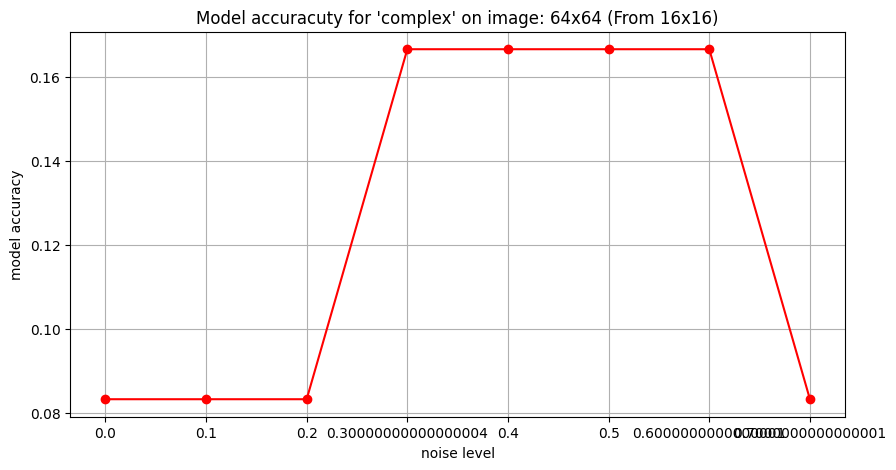

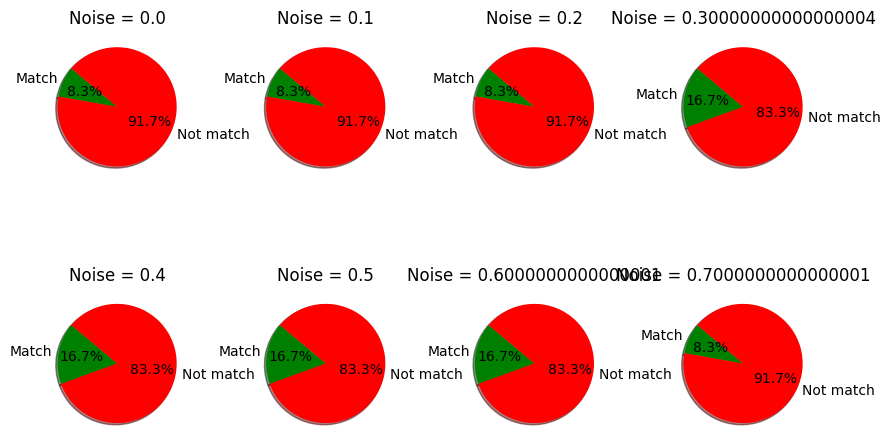

In [38]:
from matplotlib.pyplot import subplots_adjust
import matplotlib.pyplot as plt

if 'model' not in locals():
    model = LetterRecognitionModel()


model.load_state_dict(torch.load(MODEL_INSTANCE_PATH))
model.eval()

tests_loader = FromMultipleTestDataSet(IMAGE_SIZE)
used_data_set = 'hard' if USED_DIR_SIZE != 16 else 'complex'

noises = np.arange(0, 0.7+0.1, 0.1)

prediction_data = {}

for level in noises:
    count = 0
    match = 0
    for letter, data in tests_loader.form_dataset(TEST_DATA_PATH, level)[used_data_set].items():
        for test in data:

            with torch.no_grad():
                output = model(test)

            count += 1
            
            predicted_class = torch.argmax(output).item()

            predicted_class = torch.argmax(output).item()

            predicted_letter = LETTERS[predicted_class]
        
            match += 1 if predicted_letter == letter else 0 

            print(f"Noise: {level} Actual: {letter} Predicted: {predicted_letter} Check: {letter==predicted_letter}")
    
    prediction_data[f'{level}'] = (match, count)


fig = plt.figure(num=1, facecolor='w', edgecolor='k')
fig.set_figwidth(10)
fig.set_figheight(5)
subplots_adjust(hspace=0.3, wspace=0.3)

ax = fig.add_subplot(1, 1, 1)

ax.plot(
    prediction_data.keys(), 
    list(map(lambda x: float(x[0])/x[1] ,prediction_data.values())), 
    color='red', 
    linestyle='solid', 
    marker='o'
)
ax.set_title(
    f"Model accuracuty for '{used_data_set}' on image: {IMAGE_SIZE}x{IMAGE_SIZE}" \
        if IMAGE_SIZE == USED_DIR_SIZE else \
        f"Model accuracuty for '{used_data_set}' on image: {IMAGE_SIZE}x{IMAGE_SIZE} (From {USED_DIR_SIZE}x{USED_DIR_SIZE})"
)

ax.set_xlabel('noise level')
ax.set_ylabel('model accuracy')
ax.grid()
i = 1

fig = plt.figure(num=2, facecolor='w', edgecolor='k')
fig.set_figwidth(10)
fig.set_figheight(20)
subplots_adjust(hspace=-0.8, wspace=0.4)
for level in prediction_data:
    result = prediction_data[level]
    labels = 'Match', 'Not match'
    sizes = [float(result[0])/result[1], float(result[1] - result[0])/result[1]]
    colors = ['green', 'red']
    explode = (0, 0)

    ax = fig.add_subplot(2, 4, i)
    i += 1
    ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    ax.set_title(f'Noise = {level}')

plt.show()